In [40]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Import CGeo_elastic classes
import sys, os
sys.path.append(os.path.abspath('../functions'))
import CGeo_elastic as ela

# Defining the 2D elastic model (Corner edge model)

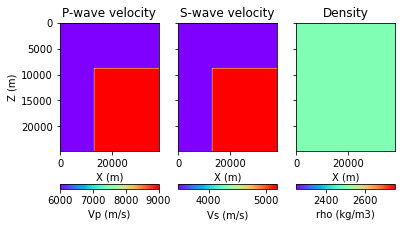

In [41]:
# Model size in grid cells
nz = 249
nx = 381
dz = 100 
dx = 100

# Corner edge model with Poisson ratio = 0.25
vpdata = np.ones([nz,nx])*6000
vpdata[89:, 131:] = 9000
rhodata = np.ones([nz,nx])*2500
lam = rhodata*(vpdata**2)/3. 
G = lam 
vsdata = np.sqrt(G/rhodata)

# Initialize 2D elastic model class and plot model
Model = ela.Elastic_model(vpdata, vsdata, rhodata, dx, dz, 0.0, 0.0) 
Model.plot()

# Source wavelet properties

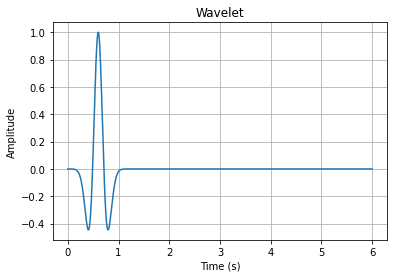

In [42]:
# Sampling and modeling length (6 seconds = (nt-1)*dt)
dt = 5e-3
nt = 1201

f0=(40/(np.pi**2))**.5  # Dominant frequency
t0=0.6 # Time delay

# Source position in grid points
sx = 150
sz = 58

# Receiver depth in grid points for the recordings
rz = 1

Source = ela.Source(nt, dt, sx, sz) # Source class
Source.Ricker(f0,t0,0) # Initializing a source wavelet
Source.plot()


# Setup finite difference modelling 

In [43]:
# Initialize the classes to solve the Elastodynamic equations
Waves = ela.Elastic_waves(Model,nt,dt) 
Derivative = ela.Derivatives()

# Create containers for snapshots 
# These require lots of memory
P_snaps = np.zeros([nz,nx,nt]) # pressure
Vx_snaps = np.zeros([nz,nx,nt]) # vx
Vz_snaps = np.zeros([nz,nx,nt]) # vz

# Create containers for seismograms
# just below the free surface
P_record= np.zeros([nt,nx]) # pressure
Vx_record = np.zeros([nt,nx]) # vx 
Vz_record = np.zeros([nt,nx]) # vz

# Check stability of FD modeling scheme
dtstab = Waves.Courant_stability(np.max(Model.vp))
if(dt > dtstab):
    raise Exception('The value of dt should not exceed the stability limit of:', dtstab, 'The value of dt was:', dt)

# Running finite difference modelling

In [44]:
# Loop over time
for it in range(0,nt):
    # Extrapolate waves one time step
    Waves.forwardStep(Derivative, Model)
    
    # Adding pressure source 
    Waves.insertPressure(Source, it)

    # Adding force source(s)
    # Clockwise angle gives force direction (180 is down)
    #angle = 180 
    #Waves.insertForce(Source, Model, angle, it)    
    
    # Recording a seismogram 
    P_record[it, :] = Waves.recordPressure(rz)
    Vx_record[it, :] = Waves.recordVelocity(rz, 'x')
    Vz_record[it, :] = Waves.recordVelocity(rz, 'z')
    
    # Record snapshots
    Vx_snaps[:,:,it] = Waves.Vx 
    Vz_snaps[:,:,it] = Waves.Vz 
    P_snaps[:,:,it] = 0.5*(Waves.Sxx + Waves.Szz) 
            
    if(it % np.floor(nt/20) == 0):
        clear_output(wait=True)
        print('Progress:', np.round(100*it/(nt-1)), '%')

Progress: 100.0 %


# Plot seismograms

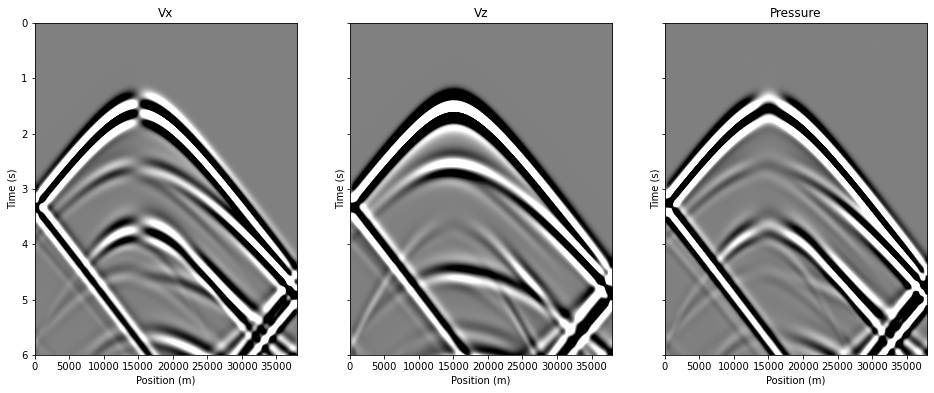

In [45]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(16,24))
extents = [0, (nx-1)*dx, (nt-1)*dt, 0]
# Vx
vlim = 0.1*np.min(Vx_record)
ax[0].imshow(Vx_record,vmin=vlim, vmax=-vlim, extent=extents, aspect=8000, cmap='gray')
ax[0].set_xlabel('Position (m)')
ax[0].set_ylabel('Time (s)')
ax[0].set_title('Vx')
# Vz
vlim = 0.1*np.min(Vz_record)
ax[1].imshow(Vz_record,vmin=vlim, vmax=-vlim, extent=extents, aspect=8000, cmap='gray')
ax[1].set_xlabel('Position (m)')
ax[1].set_ylabel('Time (s)')
ax[1].set_title('Vz')
# Pressure
vlim = 0.1*np.min(P_record)
ax[2].imshow(P_record,vmin=vlim, vmax=-vlim, extent=extents, aspect=8000, cmap='gray')
ax[2].set_xlabel('Position (m)')
ax[2].set_ylabel('Time (s)')
ax[2].set_title('Pressure')
plt.show()

# Plot snapshots

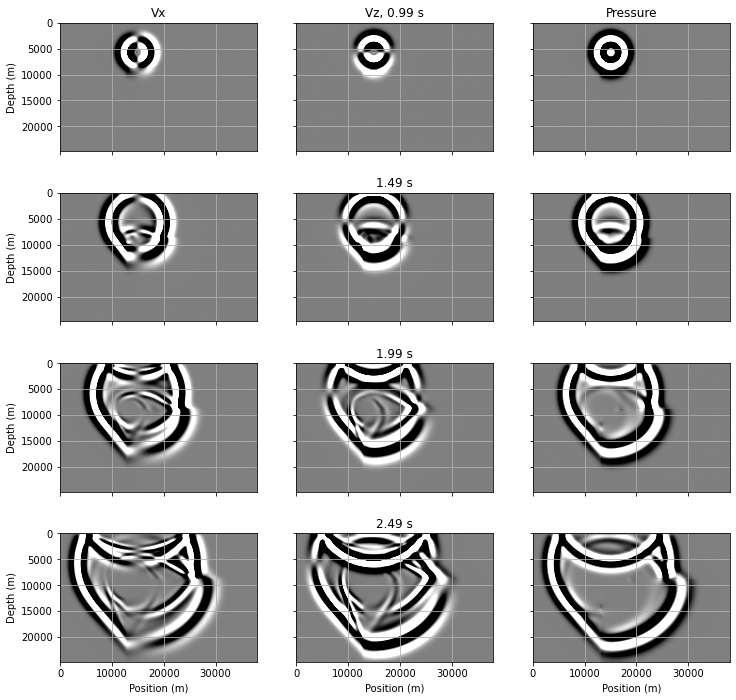

In [49]:
fig, ax = plt.subplots(4,3, sharex=True, sharey=True, figsize=(12,12))
extents = [0, (nx-1)*dx, (nz-1)*dz, 0]
snapit = int(np.floor(0.995/dt)) # initial time
delta_snap = int(np.floor(0.5/dt)) # delta time
for i in range(0,4): # 4 snaps
    # Vx
    vlim = 0.1*np.min(Vx_snaps[:,:,snapit])
    ax[i,0].imshow(Vx_snaps[:,:,snapit], vmin=vlim, vmax=-vlim, extent=extents, cmap='gray')
    ax[i,0].grid()
    ax[i,0].set_ylabel('Depth (m)')
    # Vz
    vlim = 0.1*np.min(Vz_snaps[:,:,snapit])
    ax[i,1].imshow(Vz_snaps[:,:,snapit], vmin=vlim, vmax=-vlim, extent=extents, cmap='gray')
    if i == 0:
        ax[i,1].set_title('Vz, ' + str((snapit-1)*dt) + ' s')
    else:
        ax[i,1].set_title(str((snapit-1)*dt) + ' s')
    ax[i,1].grid()
    # Pressure
    vlim = 0.1*np.min(P_snaps[:,:,snapit])
    ax[i,2].imshow(P_snaps[:,:,snapit], vmin=vlim, vmax=-vlim, extent=extents, cmap='gray')
    ax[i,2].grid()
    snapit = snapit+delta_snap

ax[0,0].set_title('Vx');
ax[0,2].set_title('Pressure');
ax[3,0].set_xlabel('Position (m)')
ax[3,1].set_xlabel('Position (m)')
ax[3,2].set_xlabel('Position (m)')

plt.show()